# Phase Picking CNN Algorithm

#### Paige Given and Albert Leonardo Aguilar Suarez - CS230

### Import Necessary Libraries

In [1]:
import numpy as np
import tensorflow as tf
import math
import h5py
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
import glob
from obspy.core import read
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import scipy.stats

In [2]:
from sklearn.model_selection import train_test_split

### Load Data

In [3]:
def generate_gaussian(mean,std=10,length=30000):
    x_values = np.arange(0,length)
    y_values = scipy.stats.norm(mean,std)
    y_values = y_values.pdf(x_values)
    #re-escale to peak at one
    y_values = y_values/np.max(y_values)
    # truncate at 2 sigmas
    y_truncated = np.zeros((30000))
    y_truncated[int(mean-2*std):int(mean+2*std)] = y_values[int(mean-2*std):int(mean+2*std)]
    
    return y_values,y_truncated

def generate_box(index1,index2):
    y_label = np.zeros((30000))
    end = int((index2-index1)*1.4)
    y_label[int(index1):int(index2)+end] = 1
    return y_label

def create_training_example(filename):
    # load the pickle file
    a_file = open(filename,'rb')
    data  = pickle.load(a_file)
    x     = data['data']
    y = np.zeros((5,30000))
    # check if the initial phase is Pg or Pn
    if data['Pn']!=0:
        box  = generate_box(data['Pn'],data['Sn'])
        _, y_pn = generate_gaussian(mean=data['Pn'])
        
    if data['Pg']!=0:
        box  = generate_box(data['Pg'],data['Sg'])
        _, y_pg = generate_gaussian(mean=data['Pg'])
        
    if data['Pn']==0:
        y_pn = np.zeros(30000)   
    if data['Pg']==0:
        y_pg = np.zeros(30000)
        
        
    if data['Sn']==0:
        y_sn = np.zeros(30000)
    if data['Sn']!=0:
        _, y_sn = generate_gaussian(mean=data['Sn'])
    
    if data['Sg']==0:
        y_sg = np.zeros(30000)
    if data['Sg']!=0:
        _,y_sg = generate_gaussian(mean=data['Sg'])
    
    #y = (box,y_pg,y_pn,y_sg,y_sn)
    
    y[0,:] = box; y[1,:] = y_pg; y[2,:] = y_pn; y[3,:] = y_sg; y[4,:] = y_sn;
    
        
    return x,y

def plot_example(x,y):
    plt.figure(figsize=(15,6))    
    for i in range(x.shape[0]):
        plt.subplot(3,1,i+1)
        
        plt.plot(x[i,:],c='k',linewidth=0.3,alpha=0.5)
        plt.plot(y[0,:],label='box')
        plt.plot(y[1,:],label='Pg');plt.plot(y[2,:],label='Pn');plt.plot(y[3,:],label='Sg');plt.plot(y[4,:],label='Sn')
        
        plt.xlim(0,30000)
        plt.legend(loc='upper right')
def load_multiple(m):
    """
    Loads m examples and concatentaes them into an input and output tensor
    """
    filenames = glob.glob('/Users/paigegiven/Desktop/CSProject/batch2/data*pkl')[:m]
    # initialize tensors
    X = np.zeros((m,3,30000))
    Y = np.zeros((m,5,30000))
    
    for i,filename in enumerate(filenames):
        x,y = create_training_example(filename)
        X[i,:,:]   = x
        Y[i,:,:]   = y
    return X,Y

In [4]:
def generate_gaussian(mean,std=10,length=30000):
    x_values = np.arange(0,length)
    y_values = scipy.stats.norm(mean,std)
    y_values = y_values.pdf(x_values)
    #re-escale to peak at one
    y_values = y_values/np.max(y_values)
    # truncate at 2 sigmas
    y_truncated = np.zeros((30000))
    y_truncated[int(mean-2*std):int(mean+2*std)] = y_values[int(mean-2*std):int(mean+2*std)]
    
    return y_values,y_truncated

def generate_box(index1,index2,length=30000):
    y_label = np.zeros((length))
    end = int((index2-index1)*1.4)
    y_label[int(index1):int(index2)+end] = 1
    return y_label

def generate_box_short(index1,index2,length=996):
    y_label = np.zeros((length))
    index1 = int(index1/30)
    index2 = int(index2/30)
    end = int((index2-index1)*1.4)
    y_label[int(index1):int(index2)+end] = 1
    return y_label

def plot_spectrogram(seismogram):
    # pass one channel at a time and fix the window values
    fs   = 100
    nfft = 128
    noverlap = 98
    spectrum,freqs,bins,im = plt.specgram(seismogram,nfft,fs,noverlap=noverlap,cmap='jet')
    return spectrum

def create_spec_one(data):
    x = plot_spectrogram(data['data'][-1])
    x = np.expand_dims(x,axis=0)
    return x

def create_spec_three(data):
    X = []
    for i in range(len(data['data'])):
        x = plot_spectrogram(data['data'][i])
        x = np.expand_dims(x,axis=0)
        X.append(x)
        # concatenate the matrices
    X = np.concatenate(X,axis=0)
    return X



def create_training_example(filename):
    # load the pickle file
    a_file = open(filename,'rb')
    data  = pickle.load(a_file)
    x     = data['data']
    y = np.zeros((5,30000))
    # check if the initial phase is Pg or Pn
    if data['Pn']!=0:
        box  = generate_box(data['Pn'],data['Sn'])
        _, y_pn = generate_gaussian(mean=data['Pn'])
        
    if data['Pg']!=0:
        box  = generate_box(data['Pg'],data['Sg'])
        _, y_pg = generate_gaussian(mean=data['Pg'])
        
    if data['Pn']==0:
        y_pn = np.zeros(30000)   
    if data['Pg']==0:
        y_pg = np.zeros(30000)
        
        
    if data['Sn']==0:
        y_sn = np.zeros(30000)
    if data['Sn']!=0:
        _, y_sn = generate_gaussian(mean=data['Sn'])
    
    if data['Sg']==0:
        y_sg = np.zeros(30000)
    if data['Sg']!=0:
        _,y_sg = generate_gaussian(mean=data['Sg'])
    
    #y = (box,y_pg,y_pn,y_sg,y_sn)
    
    y[0,:] = box; y[1,:] = y_pg; y[2,:] = y_pn; y[3,:] = y_sg; y[4,:] = y_sn;
    
        
    return x,y


def create_training_example_spec(filename):
    # load the pickle file
    a_file = open(filename,'rb')
    data  = pickle.load(a_file)
    
    if data['Pn']!=0:
        box  = generate_box_short(data['Pn'],data['Sn'])
        
    if data['Pg']!=0:
        box  = generate_box_short(data['Pg'],data['Sg'])
        
    # generate the spectrogram using just one component
    x = create_spec_one(data)
    y = box
    
    return x,y


def plot_example(x,y):
    plt.figure(figsize=(15,6)) 
    components = ['E','N','Z']
    for i in range(x.shape[0]):
        plt.subplot(3,1,i+1)
        
        plt.plot(x[i,:],c='k',linewidth=0.3,alpha=0.5)
        plt.plot(y[0,:],label='box')
        plt.plot(y[1,:],label='Pg');plt.plot(y[2,:],label='Pn');plt.plot(y[3,:],label='Sg');plt.plot(y[4,:],label='Sn')
        plt.text(1000,0.5,components[i],fontsize=18)
        
        plt.xlim(0,30000)
        plt.legend(loc='upper right',fontsize=13)
        
        
def load_multiple(m):
    """
    Loads m examples and concatentaes them into an input and output tensor
    """
    filenames = glob.glob('/Users/paigegiven/Desktop/CSProject/batch2/data*pkl')
    randint = np.random.randint(int(len(filenames)-m))
    filenames = filenames[randint:int(randint+m)]
    # initialize tensors
    X = np.zeros((m,3,30000))
    Y = np.zeros((m,5,30000))
    #Y_spec = np.zeros((m,996))
    
    for i,filename in enumerate(filenames):
        x,y = create_training_example(filename)
        X[i,:,:]   = x
        Y[i,:,:]   = y
    return X,Y


def load_multiple_spec(m):
    """
    Loads m examples and concatentaes them into an input and output tensor
    """
    
    filenames = glob.glob('/Users/paigegiven/Desktop/CSProject/batch2/data*pkl')
    randint = np.random.randint(int(len(filenames)-m))
    filenames = filenames[randint:int(randint+m)]
    
    # initialize tensors
    X = np.zeros((m,65,996))
    Y = np.zeros((m,996))
    #Y_spec = np.zeros((m,996))
    
    for i,filename in enumerate(filenames):
        x,y = create_training_example_spec(filename)
        X[i,:,:]   = x
        Y[i,:]   = y
    return X,Y


In [95]:
#X,Y = load_multiple(9663)
X,Y = load_multiple(1000)
print(X.shape,Y.shape)

(1000, 3, 30000) (1000, 5, 30000)


#### Visualization of Data

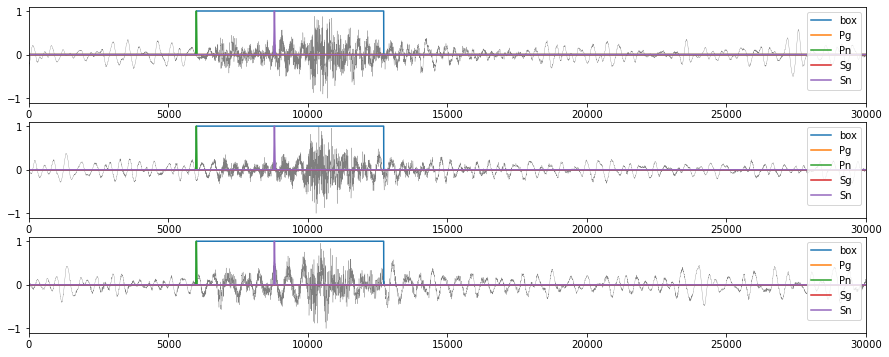

In [5]:
plot_example(X[100],Y[100])

#### Focus on One Seismic Arrival 

In [ ]:
Y = Y[:,0,:]  # this gives the Box label 
# access the labels in this order:
# 0 -> box
# 1 -> pg
# 2 -> pn
# 3 -> sg
# 4 -> sn

In [7]:
Y.shape

(1000, 30000)

#### Remove Large Outliers and Apply Clip

In [8]:
Y=np.clip(Y,0,1)

In [9]:
Y.shape

(1000, 30000)

##### Load Spectrogram Data

/Users/paigegiven/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(9000, 65, 996) (9000, 996)


/Users/paigegiven/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/Users/paigegiven/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/paigegiven/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/Users/paigegiven/anaconda3/envs/tf/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


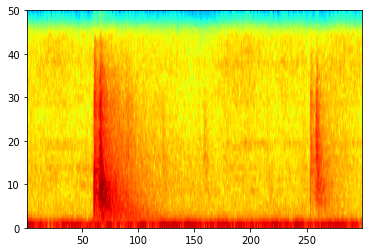

In [265]:
#X,Y = load_multiple(9663)
X,Y = load_multiple_spec(9000)
print(X.shape,Y.shape)

In [266]:
X = np.swapaxes(X,1,2)
Y = np.expand_dims(Y,axis=2)
print(X.shape,Y.shape)

(9000, 996, 65) (9000, 996, 1)


#### Divide into Training and Testing Data

In [267]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.10, random_state=42)

In [268]:
print("X_train shape = ", X_train.shape)
print("X_test shape = ", X_test.shape)
print("Y_train shape = ", Y_train.shape)
print("Y_test shape = ", Y_test.shape)

X_train shape =  (8100, 996, 65)
X_test shape =  (900, 996, 65)
Y_train shape =  (8100, 996, 1)
Y_test shape =  (900, 996, 1)


## CNN Model

### Model Set-Up

In [269]:
#Create model framework
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.001, num_epochs = 100, print_cost = True):
    return tf.keras.models.Sequential([
        keras.layers.InputLayer(input_shape=((996,65))),  
        keras.layers.Conv1D(filters=128,strides=1,kernel_size=16, padding='same'),
        tf.keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Bidirectional(LSTM(units=128,return_sequences=True)),
        tf.keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Bidirectional(keras.layers.LSTM(units=128,return_sequences=True)),
        tf.keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.2),
        keras.layers.TimeDistributed(keras.layers.Dense(1,activation='sigmoid')),
    ])

In [270]:
from tensorflow.keras.layers import LSTM

In [271]:
#Assign model with train & test variables and hyperparameters
model = model(X_train, Y_train, X_test, Y_test,learning_rate=0.001, num_epochs = 100,print_cost = True)

In [272]:
#visualize the model 
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 996, 128)          133248    
_________________________________________________________________
batch_normalization_47 (Batc (None, 996, 128)          512       
_________________________________________________________________
activation_34 (Activation)   (None, 996, 128)          0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 996, 128)          0         
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 996, 256)          263168    
_________________________________________________________________
batch_normalization_48 (Batc (None, 996, 256)          1024      
_________________________________________________________________
activation_35 (Activation)   (None, 996, 256)        

### CTC Loss Function 

In [273]:
loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

### Compile and Run Model

In [274]:
optim = tf.keras.optimizers.Adam(learning_rate=0.00005,beta_1=0.9,beta_2=0.999,decay=0.00001)
#optim = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD")
model.compile(optimizer=optim,loss=loss,metrics=['accuracy','binary_crossentropy','mse'])

Epoch 1/10
254/254 [==============================] - 697s 3s/step - loss: 0.4301 - accuracy: 0.8557 - binary_crossentropy: 0.4301 - mse: 0.1195
Epoch 2/10
254/254 [==============================] - 721s 3s/step - loss: 0.2404 - accuracy: 0.9165 - binary_crossentropy: 0.2404 - mse: 0.0652
Epoch 3/10
254/254 [==============================] - 763s 3s/step - loss: 0.2089 - accuracy: 0.9222 - binary_crossentropy: 0.2090 - mse: 0.0592
Epoch 4/10
254/254 [==============================] - 758s 3s/step - loss: 0.1981 - accuracy: 0.9253 - binary_crossentropy: 0.1981 - mse: 0.0569
Epoch 5/10
254/254 [==============================] - 696s 3s/step - loss: 0.1899 - accuracy: 0.9276 - binary_crossentropy: 0.1899 - mse: 0.0550
Epoch 6/10
254/254 [==============================] - 713s 3s/step - loss: 0.1855 - accuracy: 0.9289 - binary_crossentropy: 0.1855 - mse: 0.0539
Epoch 7/10
254/254 [==============================] - 733s 3s/step - loss: 0.1794 - accuracy: 0.9311 - binary_crossentropy: 0.1795

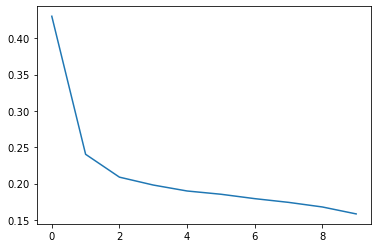

In [275]:
history=model.fit(X_train, Y_train,epochs=10,batch_size=32,shuffle=True)
plt.plot(history.history['loss'])

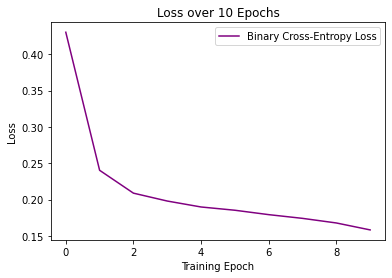

In [346]:
plt.plot(history.history['loss'],color='purple',label='Binary Cross-Entropy Loss')
plt.title('Loss over 10 Epochs')
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.legend()

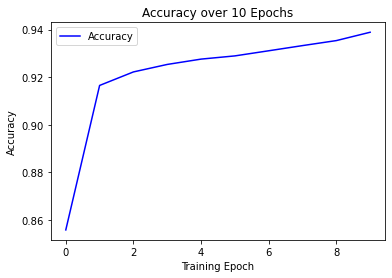

In [347]:
plt.plot(history.history['accuracy'],color='b',label='Accuracy')
plt.title('Accuracy over 10 Epochs')
plt.xlabel('Training Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [276]:
model.save('mod1')

INFO:tensorflow:Assets written to: mod1/assets


INFO:tensorflow:Assets written to: mod1/assets


### Evaluate Model

### Run Model on Training Data to get Predictions

In [277]:
predictions = model.predict(X_train)
print(predictions[100].shape)
print(predictions[100])

(996, 1)
[[ 0.01497191]
 [ 0.00654584]
 [ 0.00469649]
 [ 0.00414196]
 [ 0.0038555 ]
 [ 0.00371921]
 [ 0.00366086]
 [ 0.00364515]
 [ 0.00363216]
 [ 0.00361648]
 [ 0.0036073 ]
 [ 0.00360203]
 [ 0.00361219]
 [ 0.0036335 ]
 [ 0.00366852]
 [ 0.00371438]
 [ 0.00377011]
 [ 0.00383618]
 [ 0.00391081]
 [ 0.00399297]
 [ 0.00407782]
 [ 0.00416493]
 [ 0.00425422]
 [ 0.0043487 ]
 [ 0.00445065]
 [ 0.00455567]
 [ 0.00457549]
 [ 0.00459567]
 [ 0.00461873]
 [ 0.00464395]
 [ 0.00466993]
 [ 0.00469863]
 [ 0.00473019]
 [ 0.00476861]
 [ 0.00480926]
 [ 0.00484616]
 [ 0.00488091]
 [ 0.00492322]
 [ 0.00496849]
 [ 0.00501662]
 [ 0.00506639]
 [ 0.00511733]
 [ 0.00517228]
 [ 0.00523061]
 [ 0.00527996]
 [ 0.00533736]
 [ 0.00539762]
 [ 0.00546497]
 [ 0.00552747]
 [ 0.00558376]
 [ 0.00563204]
 [ 0.00567353]
 [ 0.00571549]
 [ 0.00575644]
 [ 0.00578094]
 [ 0.00580767]
 [ 0.0058383 ]
 [ 0.00587586]
 [ 0.00592345]
 [ 0.00598148]
 [ 0.00604108]
 [ 0.00609669]
 [ 0.0061394 ]
 [ 0.00606817]
 [ 0.00597119]
 [ 0.0059059 ]
 

##### Training Score

In [343]:
model.evaluate(X_train, Y_train, verbose=1)

254/254 [==============================] - 165s 634ms/step - loss: 0.1946 - accuracy: 0.9287 - binary_crossentropy: 0.1948 - mse: 0.0537


[0.19463752210140228,
 0.9287391304969788,
 0.19476503133773804,
 0.05374515429139137]

##### Testing Score

In [344]:
model.evaluate(X_test, Y_test, verbose=1)

29/29 [==============================] - 18s 618ms/step - loss: 0.1993 - accuracy: 0.9278 - binary_crossentropy: 0.1993 - mse: 0.0551


[0.1992584615945816,
 0.9277989864349365,
 0.19931165874004364,
 0.055078085511922836]

(0.0, 1000.0)

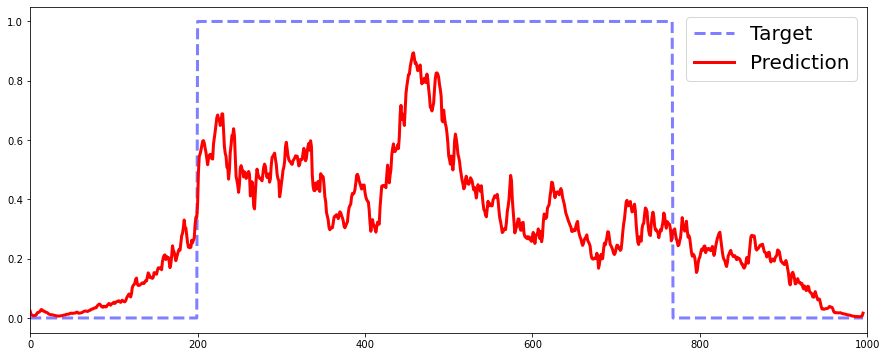

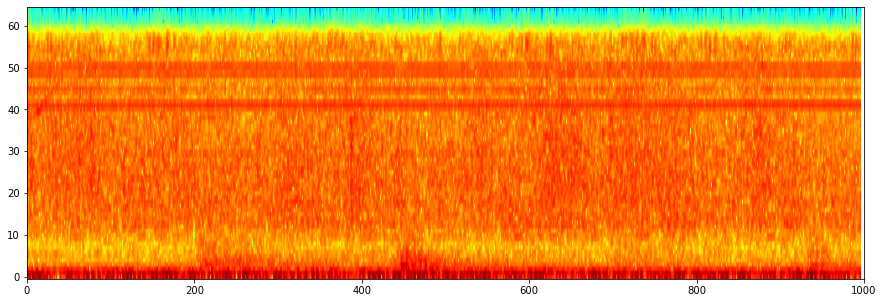

In [351]:
plt.figure(figsize=(15,6)) 
#plt.subplot(3,1,i+1)
plt.plot(Y_train[50],c='b',linestyle='dashed',linewidth=3,alpha=0.5,label='Target')
plt.plot(predictions[50],c='r',linewidth=3,label='Prediction')
#plt.plot(y[1,:],label='Pg');plt.plot(y[2,:],label='Pn');plt.plot(y[3,:],label='Sg');plt.plot(y[4,:],label='Sn')
plt.xlim(0,1000)
plt.legend(loc='upper right',fontsize=20)
plt.figure(figsize=(15,5)) 
plt.imshow(np.log(X_train[50,:,:].T),cmap='jet',aspect='auto',origin='lower')
plt.xlim(0,1000)

# CNN Model 2 - Using 3 input components separately

### The input is created by concatenating the spectrograms of each component

Here, we employ the same architecture as we did before, but compile the model to take a differently shaped input. Previously, each training example was of shape (996,65), but now, by concatenating three of these along the second axis, we get an input of shape (996,195). As a consequence, a batch of $m$ examples is of shape (m,996,195).

### Load New Formatted Data

In [5]:
def create_spec_three(data):
    X = []
    for i in range(len(data['data'])):
        x = plot_spectrogram(data['data'][i])
        x = np.expand_dims(x,axis=0)
        X.append(x)
        # concatenate the matrices
    X = np.concatenate(X,axis=0)
    return X

def create_spec_three_stack(data):
    X = []
    for i in range(len(data['data'])):
        x = plot_spectrogram(data['data'][i])
        #x = np.expand_dims(x,axis=0)
        X.append(x)
        # concatenate the matrices
    X = np.concatenate(X,axis=0)
    return X

def create_training_example_spec_three(filename):
    a_file = open(filename,'rb')
    data  = pickle.load(a_file)
    if data['Pn']!=0:
        box  = generate_box_short(data['Pn'],data['Sn'])
        
    if data['Pg']!=0:
        box  = generate_box_short(data['Pg'],data['Sg'])
        
    x = create_spec_three_stack(data)
    y = box
    
    return x,y
    
def create_training_example_spec_three_stack(filename):
    a_file = open(filename,'rb')
    data  = pickle.load(a_file)
    if data['Pn']!=0:
        box  = generate_box_short(data['Pn'],data['Sn'])
        
    if data['Pg']!=0:
        box  = generate_box_short(data['Pg'],data['Sg'])
        
    x = create_spec_three_stack(data)
    y = box
    
    return x,y

def load_multiple_spec_three(m):
    filenames = glob.glob('batch2/data*pkl')
    randint   = np.random.randint(int(len(filenames)-m))
    filenames = filenames[randint:int(randint+m)]  
    
    # initialize tensors
    X = np.zeros((m,195,996))
    Y = np.zeros((m,996))
    for i,filename in enumerate(filenames):
        x,y = create_training_example_spec_three(filename)
        X[i,:,:]   = x
        Y[i,:]   = y
    return X,Y


In [ ]:
X2,Y2 = load_multiple_spec_three(9000)

/Users/paigegiven/anaconda3/envs/tf/lib/python3.7/site-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [7]:
X2 = np.swapaxes(X2,1,2)
Y2 = np.expand_dims(Y2,axis=2)
print(X2.shape,Y2.shape)

(9000, 996, 195) (9000, 996, 1)


### Divide new data into training and testing data

In [8]:
X_train2,X_test2,Y_train2,Y_test2=train_test_split(X2,Y2,test_size=0.10, random_state=42)

In [9]:
print("X_train shape = ", X_train2.shape)
print("X_test shape = ", X_test2.shape)
print("Y_train shape = ", Y_train2.shape)
print("Y_test shape = ", Y_test2.shape)

X_train shape =  (8100, 996, 195)
X_test shape =  (900, 996, 195)
Y_train shape =  (8100, 996, 1)
Y_test shape =  (900, 996, 1)


### Model2 Set-Up

In [17]:
#Create model framework
def model2(X_train, Y_train, X_test, Y_test, learning_rate = 0.001, num_epochs = 100, print_cost = True):
    return tf.keras.models.Sequential([
        keras.layers.InputLayer(input_shape=((996,195))),  
        keras.layers.Conv1D(filters=128,strides=1,kernel_size=16, padding='same'),
        tf.keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Bidirectional(LSTM(units=128,return_sequences=True)),
        tf.keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Bidirectional(keras.layers.LSTM(units=128,return_sequences=True)),
        tf.keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dropout(0.2),
        keras.layers.TimeDistributed(keras.layers.Dense(1,activation='sigmoid')),
    ])

In [18]:
from tensorflow.keras.layers import LSTM

In [19]:
#Assign model with train & test variables and hyperparameters
model2 = model2(X_train2, Y_train2, X_test2, Y_test2,learning_rate=0.001, num_epochs = 100,print_cost = True)

In [20]:
#visualize the model 
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 996, 128)          399488    
_________________________________________________________________
batch_normalization_3 (Batch (None, 996, 128)          512       
_________________________________________________________________
activation_3 (Activation)    (None, 996, 128)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 996, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 996, 256)          263168    
_________________________________________________________________
batch_normalization_4 (Batch (None, 996, 256)          1024      
_________________________________________________________________
activation_4 (Activation)    (None, 996, 256)         

### CTC Loss Function 

In [21]:
loss = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)

### Compile and Run Model2

In [22]:
optim = tf.keras.optimizers.Adam(learning_rate=0.00005,beta_1=0.9,beta_2=0.999,decay=0.00001)
#optim = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD")
model2.compile(optimizer=optim,loss=loss,metrics=['accuracy','binary_crossentropy','mse'])

In [ ]:
history2=model2.fit(X_train2, Y_train2,epochs=10,batch_size=32,shuffle=True)
plt.plot(history2.history['loss'])

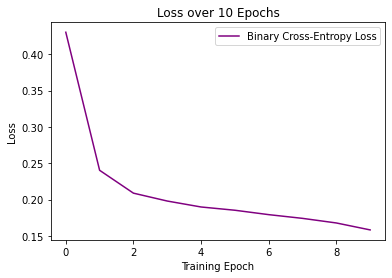

In [346]:
plt.plot(history2.history['loss'],color='purple',label='Binary Cross-Entropy Loss')
plt.title('Loss over 10 Epochs - New Data Format Run')
plt.xlabel('Training Epoch')
plt.ylabel('Loss')
plt.legend()

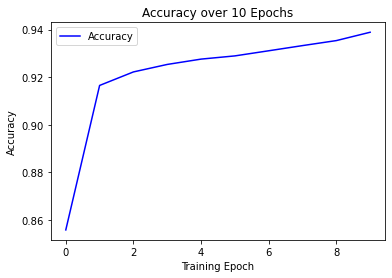

In [347]:
plt.plot(history2.history['accuracy'],color='b',label='Accuracy')
plt.title('Accuracy over 10 Epochs - New Data Format Run')
plt.xlabel('Training Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [276]:
model2.save('mod2')

INFO:tensorflow:Assets written to: mod1/assets


INFO:tensorflow:Assets written to: mod1/assets


### Evaluate Model2

### Run Model2 on Training Data to get Predictions

In [277]:
predictions2 = model2.predict(X_train2)
print(predictions2[100].shape)
print(predictions2[100])

(996, 1)
[[ 0.01497191]
 [ 0.00654584]
 [ 0.00469649]
 [ 0.00414196]
 [ 0.0038555 ]
 [ 0.00371921]
 [ 0.00366086]
 [ 0.00364515]
 [ 0.00363216]
 [ 0.00361648]
 [ 0.0036073 ]
 [ 0.00360203]
 [ 0.00361219]
 [ 0.0036335 ]
 [ 0.00366852]
 [ 0.00371438]
 [ 0.00377011]
 [ 0.00383618]
 [ 0.00391081]
 [ 0.00399297]
 [ 0.00407782]
 [ 0.00416493]
 [ 0.00425422]
 [ 0.0043487 ]
 [ 0.00445065]
 [ 0.00455567]
 [ 0.00457549]
 [ 0.00459567]
 [ 0.00461873]
 [ 0.00464395]
 [ 0.00466993]
 [ 0.00469863]
 [ 0.00473019]
 [ 0.00476861]
 [ 0.00480926]
 [ 0.00484616]
 [ 0.00488091]
 [ 0.00492322]
 [ 0.00496849]
 [ 0.00501662]
 [ 0.00506639]
 [ 0.00511733]
 [ 0.00517228]
 [ 0.00523061]
 [ 0.00527996]
 [ 0.00533736]
 [ 0.00539762]
 [ 0.00546497]
 [ 0.00552747]
 [ 0.00558376]
 [ 0.00563204]
 [ 0.00567353]
 [ 0.00571549]
 [ 0.00575644]
 [ 0.00578094]
 [ 0.00580767]
 [ 0.0058383 ]
 [ 0.00587586]
 [ 0.00592345]
 [ 0.00598148]
 [ 0.00604108]
 [ 0.00609669]
 [ 0.0061394 ]
 [ 0.00606817]
 [ 0.00597119]
 [ 0.0059059 ]
 

##### Training Score

In [343]:
model2.evaluate(X_train2, Y_train2, verbose=1)

254/254 [==============================] - 165s 634ms/step - loss: 0.1946 - accuracy: 0.9287 - binary_crossentropy: 0.1948 - mse: 0.0537


[0.19463752210140228,
 0.9287391304969788,
 0.19476503133773804,
 0.05374515429139137]

##### Testing Score

In [344]:
model2.evaluate(X_test2, Y_test2, verbose=1)

29/29 [==============================] - 18s 618ms/step - loss: 0.1993 - accuracy: 0.9278 - binary_crossentropy: 0.1993 - mse: 0.0551


[0.1992584615945816,
 0.9277989864349365,
 0.19931165874004364,
 0.055078085511922836]

#### Visualize Results

(0.0, 1000.0)

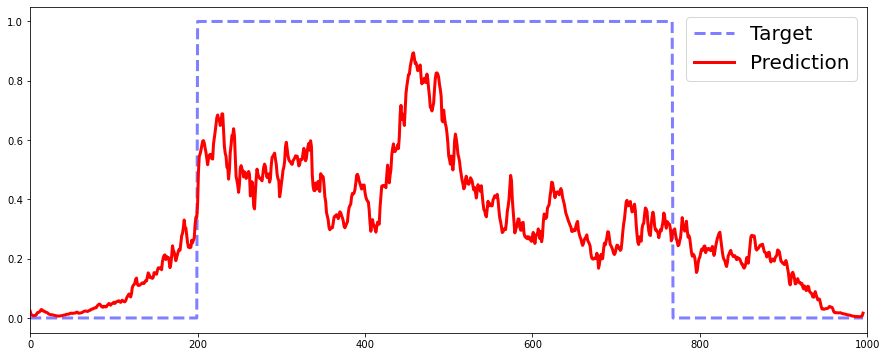

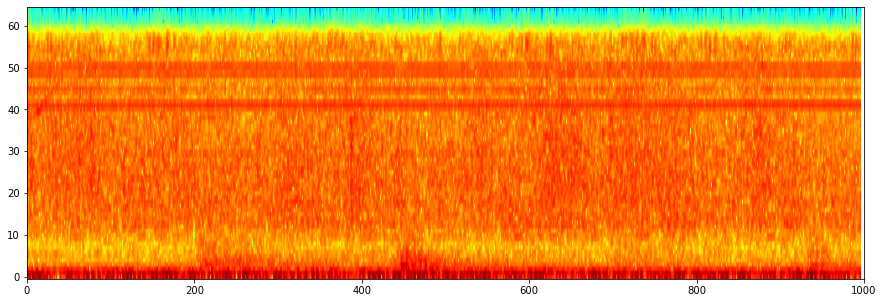

In [351]:
plt.figure(figsize=(15,6)) 
#plt.subplot(3,1,i+1)
plt.plot(Y_train2[50],c='b',linestyle='dashed',linewidth=3,alpha=0.5,label='Target')
plt.plot(predictions2[50],c='r',linewidth=3,label='Prediction')
#plt.plot(y[1,:],label='Pg');plt.plot(y[2,:],label='Pn');plt.plot(y[3,:],label='Sg');plt.plot(y[4,:],label='Sn')
plt.xlim(0,1000)
plt.legend(loc='upper right',fontsize=20)
plt.figure(figsize=(15,5)) 
plt.imshow(np.log(X_train2[50,:,:].T),cmap='jet',aspect='auto',origin='lower')
plt.xlim(0,1000)